In [1]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
df_ds = pd.read_csv('./job_summaries/output_data_scientist.csv')
df_da = pd.read_csv('./job_summaries/output-data-analyst.csv')
df_de = pd.read_csv('./job_summaries/output-data-engineer.csv')
df_bi = pd.read_csv('./job_summaries/output-bi.csv')

frames = pd.concat([df_ds, df_da, df_de, df_bi])
df_ds.head()

,job_title,company_name,summary
0,Data Scientist,Apple,"Imagine what you could do here. At Apple, grea..."
1,Junior Data Scientist,The World Bank,WORLD BANK GROUP CONTEXT\n\nDevelopment data ...
2,Data Scientist,Crossover,Are you eager to join a network of the most ta...
3,Junior Data Scientist- Statistician,McAfee,Job Description\n\nThe Test & Learn Marketing ...
4,Data Scientist,Wiser,About us :\nWiser is the leading provider of a...


In [4]:
import json
from itertools import chain

skills_json = pd.read_json('linkedin_topics_7-23-17.json')

tmp_skills = skills_json.apply(
    lambda x : list(chain.from_iterable([list(x['skills'].keys()) if x['skills'] is not None else [],
                                         x['topSkills'] if x['topSkills'] is not None else []])), axis = 1)

skills_list = list(set(chain.from_iterable(tmp_skills)))

skills_list = [x.lower() for x in skills_list]

In [ ]:
"""skills_list = ['python', 'sql', 'hadoop', 'spark', 'aws', 'r', 'big data', 'machine learning', 'deep learning',
               'sklearn', 'scikit-learn', 'HTML5' , 'javascript', 'jquery', 'excel', 'powerpoint', 'scala', 'java',
              'c++', 'hive', 'NLP', 'CART', 'SVM', 'regression', 'statistics', 'mapreduce', 'tableau', 'PyTorch' , 'TensorFlow', 
               'Theano', 'Keras', 'algorithms', 'Linear Models', 'Neural Networks', 'Decision Trees', 'Bayesian', 'Clustering',
               'Anomaly Detection', 'data mining']"""

In [5]:
from collections import Counter
import re
import matplotlib.pylab as plt
%matplotlib inline

class SkillsExtractor():
    
    def __init__(self, job_summaries_df, skills_list, nb_top_skills, job_title):
        self.job_summaries_df = job_summaries_df
        self.skills_list = skills_list
        self.nb_top_skills = nb_top_skills
        self.job_title = job_title
        
    def get_occurences(self, textfile):

        skills_dict  = {x : 0 for x in self.skills_list}

        cnt = Counter()
        words = re.findall('[A-Za-z+]+', textfile.lower())
        skills_dict = {skill.title() : 100 if Counter(words)[skill] > 0 else 0 for skill, ind in skills_dict.items()}
        
        # Deal with double word skill
    
        for skill in list(skills_dict.keys()):

            if ' ' in skill: 
                double_word_skill = True if skill.lower() in textfile.lower() else False                
                skills_dict[skill.title()] = 100 if double_word_skill else 0 
        return skills_dict

    def get_skills_df(self, column_name):

        skills_df = pd.DataFrame(columns=[x.title() for x in self.skills_list])

        for ind, job_desc in enumerate(self.job_summaries_df[column_name]):
            if ind % 200 == 0:
                print("Job description n°%i" % ind)

            skills_occurences = self.get_occurences(job_desc)
            skills_df = skills_df.append(skills_occurences, ignore_index = True)

        return skills_df

    def extract_skills(self, column_name):

        new_df = self.job_summaries_df.copy()
        skills_df = self.get_skills_df(column_name)
        new_df = new_df.merge(skills_df, right_index=True, left_index=True)

        return new_df

    def get_top_n_skills_with_features(self, js_with_skills_df):
        
        skills_dict = js_with_skills_df[js_with_skills_df.columns[3:]].sum().apply(
            lambda x : x / len(js_with_skills_df)
        ).to_dict()
        
        top = self.nb_top_skills

        if top > len(skills_dict):
            top = len(skills_dict)
        
        top_n_skills = dict(Counter(skills_dict).most_common(top))
        
        return top_n_skills
    
    def get_top_skills(self, ):
        new_df_ds = self.extract_skills('summary')
        top_n_dict = self.get_top_n_skills_with_features(new_df_ds)

        print("The top %i skills are :" % self.nb_top_skills)
        for i in range(self.nb_top_skills):
            print("%i : %s (%.2f%%)" % 
                  (i+1, list(top_n_dict.keys())[i], list(top_n_dict.values())[i]))
        
        self.plot_top_skills(top_n_dict)
        return top_n_dict
    
    def plot_top_skills(self, top_dict):
        plt.figure(figsize = (15,8))
        plt.bar(range(len(top_dict)), list(top_dict.values()), align='center');
        plt.xticks(range(len(top_dict)), list(top_dict.keys()), rotation='vertical');
        plt.xlabel("Skills")
        plt.ylabel("% occurence among all job summaries")
        plt.title('Most important skills as a ' + self.job_title)
        

Job description n°0
Job description n°200
Job description n°400
Job description n°600
Job description n°800
The top 20 skills are :
1 : Python (66.79%)
2 : Statistics (61.40%)
3 : Research (55.76%)
4 : Engineering (50.86%)
5 : Software (47.79%)
6 : Modeling (47.43%)
7 : Programming (46.69%)
8 : Algorithms (42.16%)
9 : Mathematics (37.50%)
10 : Mining (32.60%)
11 : Scientists (30.39%)
12 : Religion (29.04%)
13 : Education (28.31%)
14 : Sas (27.45%)
15 : Hadoop (27.08%)
16 : Visualization (25.98%)
17 : Java (25.49%)
18 : Spark (23.41%)
19 : Optimization (22.30%)
20 : Engineers (20.34%)


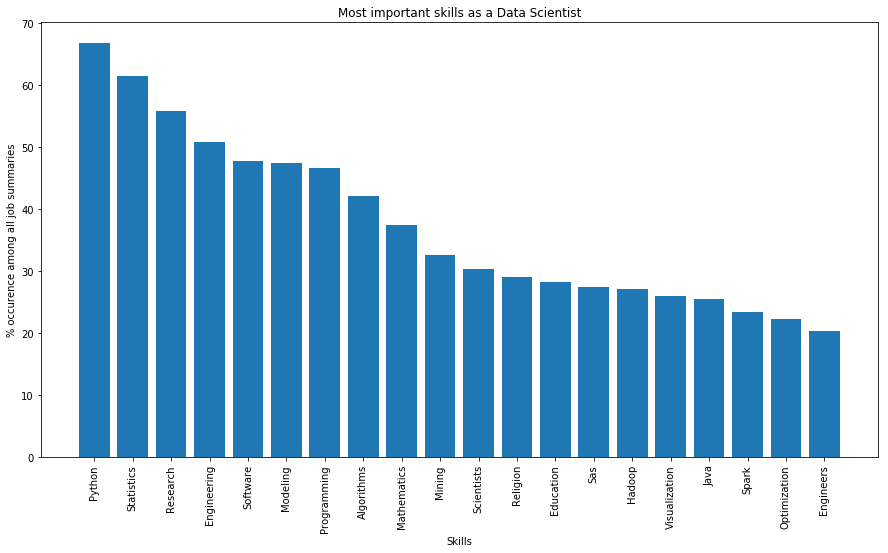

In [20]:
sk_ds = SkillsExtractor(df_ds, vocab_inter, 20, 'Data Scientist')
do_ds = sk_ds.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
The top 20 skills are :
1 : Reporting (46.42%)
2 : Research (38.11%)
3 : Statistics (37.85%)
4 : Software (37.34%)
5 : Education (33.50%)
6 : Engineering (29.67%)
7 : Python (27.75%)
8 : Databases (26.21%)
9 : Programming (25.06%)
10 : Religion (23.79%)
11 : Intelligence (23.15%)
12 : Modeling (23.02%)
13 : Tableau (22.12%)
14 : Training (21.23%)
15 : Mathematics (20.97%)
16 : Sas (20.59%)
17 : Visualization (19.69%)
18 : Writing (18.54%)
19 : Metrics (18.54%)
20 : Marketing (18.41%)


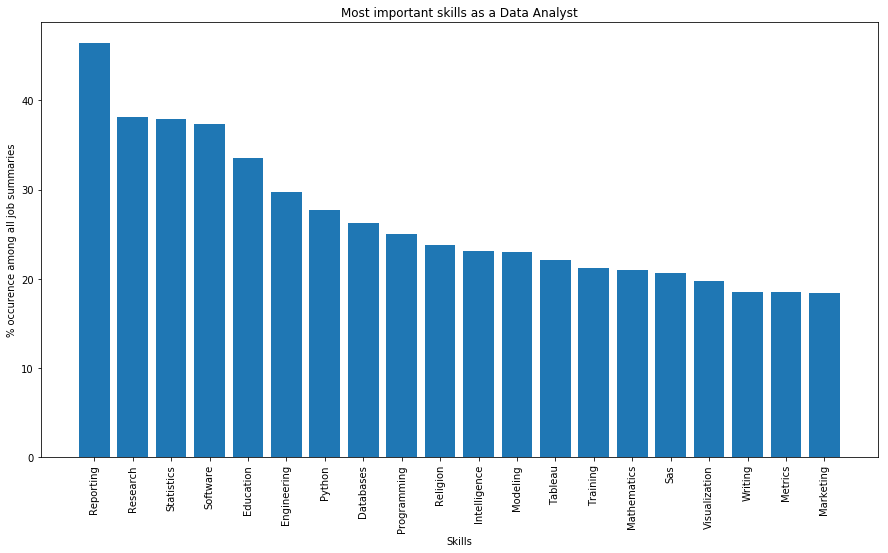

In [9]:
sk_da = SkillsExtractor(df_da, vocab_inter, 20, 'Data Analyst')
do_da = sk_da.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
Job description n°800
The top 10 skills are :
1 : Engineering (65.04%)
2 : Software (60.55%)
3 : Python (58.68%)
4 : Java (45.44%)
5 : Engineers (40.70%)
6 : Programming (39.70%)
7 : Hadoop (38.83%)
8 : Spark (37.45%)
9 : Infrastructure (29.59%)
10 : Databases (29.46%)


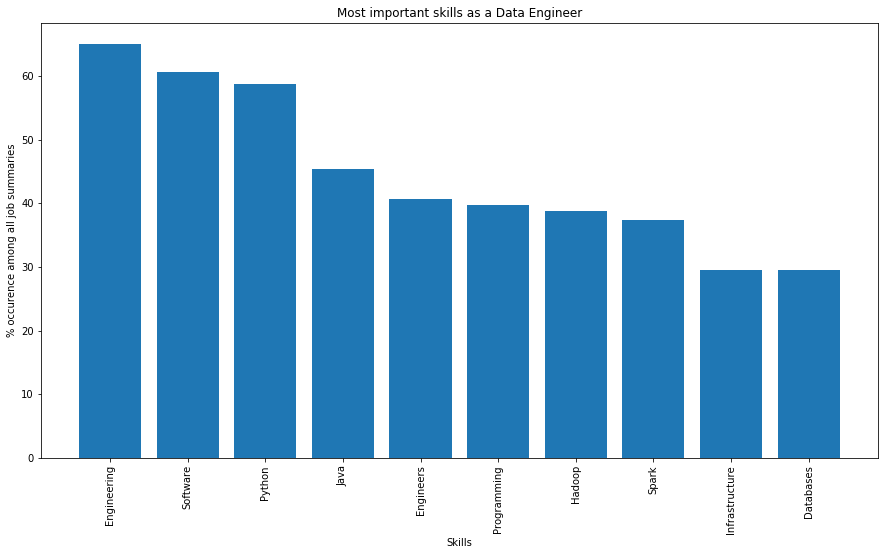

In [12]:
sk_de = SkillsExtractor(df_de, vocab_inter, 10, 'Data Engineer')
do_de = sk_de.get_top_skills()

Job description n°0
Job description n°200
Job description n°400
Job description n°600
The top 10 skills are :
1 : Intelligence (77.79%)
2 : Reporting (69.16%)
3 : Tableau (38.32%)
4 : Education (36.93%)
5 : Software (35.15%)
6 : Modeling (30.46%)
7 : Engineering (29.19%)
8 : Research (26.78%)
9 : Visualization (26.78%)
10 : Databases (26.65%)


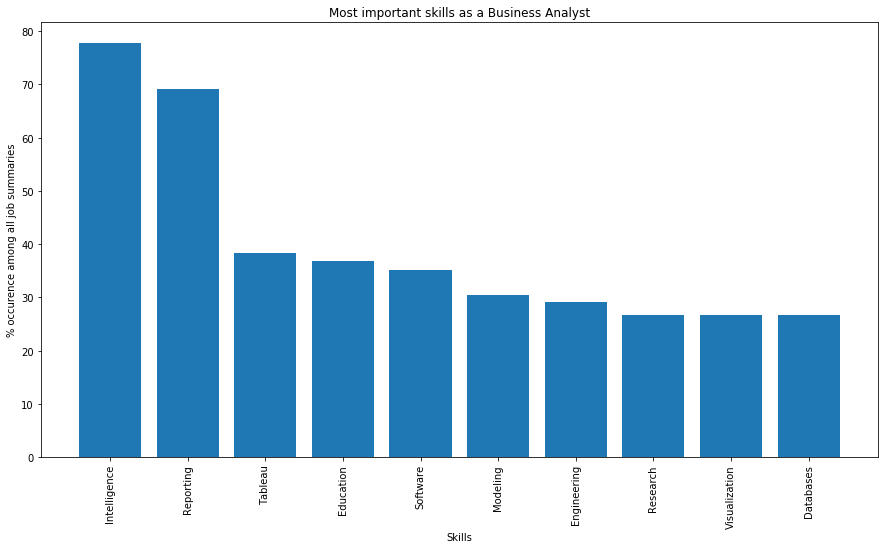

In [13]:
sk_bi = SkillsExtractor(df_bi, vocab_inter, 10, 'Business Analyst')
do_bi = sk_bi.get_top_skills()

## Extract skills paragraph

In [154]:
def get_skills_part(textfile):
    keywords = ['qualifications', 'skills', 'requirements', 'required', 'experience']
    signs = [':', '\n']
    
    skill_part_found = False
    
    for keyword in keywords:
        skills_part = textfile
        still_keyword = True
        
        while still_keyword:

            try:
                keyword_index = skills_part.lower().index(keyword)

                skills_part = skills_part[keyword_index:]
                test_sign = False
                for sign in signs:
                    try:
                        sign_index = skills_part.lower().index(sign)
                        if sign_index - len(keyword) < 15:
                            test_sign = True
                            break
                    except:
                        pass
                if test_sign == True:
                    if len(skills_part[len(keyword):]) > 100:
                        skill_part_found = True
                        break
                    else:
                        test_sign = False

                skills_part = skills_part[len(keyword):]
            except:
                still_keyword = False
        if skill_part_found:
            break
                
    if skill_part_found != True:
        print("No qualifications part found... \n")
        skills_part = 'No skills found'
        
    return skills_part

# LDA

## Without N grams

In [53]:
df_raw = frames['summary'].values

# Filter words in a trivial way (stop words, max/min df)

tf_vectorizer_1gram = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                #token_pattern = r'\b[a-zA-Z]{3,}\b', # more than 3 characters
                                max_df = 0.5,  # Ten that appear in more than 50% of documents
                                min_df = 50,
                                ) # Terms that appear in less than ten documents


tf_vectorizer_1gram.fit(df_raw) # Extract vocabulary from job descriptions
print(len(tf_vectorizer_1gram.vocabulary_))

# Returns intersection with Linkedin skills
vocab_inter = [k for k in tf_vectorizer_1gram.vocabulary_.keys() if k in skills_list]
len(vocab_inter)

# Computes count with relevant vocabulary

tf_vectorizer_1gram = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                vocabulary = vocab_inter, # CONSIDER ONLY RELEVANT VOCABULARY
                                lowercase = True,
                                #token_pattern = r'\b[a-zA-Z]{3,}\b', # more than 3 characters
                                #max_df = 0.5,  # Taken into account previously
                                #min_df = 50,
                                ) 

dtm_tf = tf_vectorizer_1gram.fit_transform(df_raw)

2159


In [54]:
lda_tf = LatentDirichletAllocation(n_components=6, random_state=0)
lda_tf.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer_1gram)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      21.188374        1       1  0.291694  0.012220
5      21.081852        1       2 -0.034351  0.011130
3      20.038085        1       3  0.086302 -0.010154
2      16.640870        1       4 -0.125014  0.173777
0      10.551477        1       5 -0.106520 -0.276000
4      10.499342        1       6 -0.112111  0.089028, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
194   Default  3056.000000      reporting  3056.000000  30.0000  30.0000
154   Default   909.000000            com   909.000000  29.0000  29.0000
16    Default  2541.000000       research  2541.000000  28.0000  28.0000
54    Default  1156.000000      marketing  1156.000000  27.0000  27.0000
129   Default   663.000000      insurance   663.000000  26.0000  26.0000
64    Default  2676.000000   intelligence  2676.000000  25.0000  25.0000
104   Default   780.000000            sas   780.000000  24.0000  24.0000
6     Default  1549.000000     statistics  1549.000000  23.0000  23.0000
1     Default   978.000000     algorithms   978.000000  22.0000  22.0000
61    Default  1021.000000       security  1021.000000  21.0000  21.0000
58    Default   638.000000        finance   638.000000  20.0000  20.0000
31    Default   941.000000        tableau   941.000000  19.0000  19.0000
8     Default   796.000000          spark   796.000000  18.0000  18.0000
9     Default   939.000000         hadoop   939.000000  17.0000  17.0000
4     Default  3261.000000       software  3261.000000  16.0000  16.0000
196   Default   612.000000          sales   612.000000  15.0000  15.0000
7     Default   882.000000           java   882.000000  14.0000  14.0000
165   Default   639.000000  documentation   639.000000  13.0000  13.0000
24    Default  1620.000000       modeling  1620.000000  12.0000  12.0000
52    Default   373.000000   compensation   373.000000  11.0000  11.0000
23    Default  1766.000000         python  1766.000000  10.0000  10.0000
174   Default   309.000000         credit   309.000000   9.0000   9.0000
85    Default   880.000000      engineers   880.000000   8.0000   8.0000
70    Default   851.000000       religion   851.000000   7.0000   7.0000
5     Default  2634.000000    engineering  2634.000000   6.0000   6.0000
0     Default   679.000000     scientists   679.000000   5.0000   5.0000
117   Default   683.000000        metrics   683.000000   4.0000   4.0000
82    Default   266.000000         supply   266.000000   3.0000   3.0000
27    Default   781.000000    mathematics   781.000000   2.0000   2.0000
225   Default   278.000000          visit   278.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
258    Topic6    21.804282     discretion    59.214311   1.2548  -6.0483
151    Topic6    26.739974       spectrum    73.031181   1.2491  -5.8443
208    Topic6    23.267117           nyse    63.969849   1.2425  -5.9834
253    Topic6    22.764310   corporations    64.269054   1.2160  -6.0052
22     Topic6    83.838244     validation   237.460559   1.2127  -4.7015
197    Topic6    32.778033     relocation    94.290094   1.1972  -5.6407
201    Topic6    53.809545           root   156.863458   1.1839  -5.1450
223    Topic6    24.077572        cluster    70.340832   1.1818  -5.9491
131    Topic6    48.802957       teamwork   150.072880   1.1305  -5.2426
181    Topic6    62.744514          video   196.306787   1.1133  -4.9913
153    Topic6    32.955334   perspectives   103.302193   1.1114  -5.6353
168    Topic6    55.498139     conducting   177.029919   1.0939  -5.1141
24     Topic6   494.075452       modeling  1620.731739   1.0659  -2.9277
27     Topic6   219.561531    mathematics   781.359398   0.9845  -3.7388
6      Topic6   349.202229     statistics  1549.383878   0.7639  -3.2748
65     Topic6   185.7

## LDA with N Grams

In [37]:
tf_vectorizer_new = CountVectorizer(strip_accents = 'unicode',
                                
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b', # more than 3 characters
                                max_df = 0.5,  # Ten that appear in more than 50% of documents
                                min_df = 50,
                                ngram_range = (1,@)
                                ) # Terms that appear in less than ten documents

dtm_tf = tf_vectorizer_new.fit_transform(df_raw)
vocab_inter = [k for k in tf_vectorizer_new.vocabulary_.keys() if k in skills_list]
len(vocab_inter)

281

In [38]:
# lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)

# tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
# dtm_tfidf = tfidf_vectorizer.fit_transform(df_ds_raw)

# lda_tfidf.fit(dtm_tfidf)

In [39]:
# pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tf_vectorizer)